In [1]:
import argparse

import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from ema_pytorch import EMA
from torchinfo import summary
from lightning import Trainer
from lightning.pytorch.loggers import WandbLogger

from nn_zoo.datamodules import MNISTDataModule
from nn_zoo.models.components import ResidualStack, DepthwiseSeparableConv2d
from nn_zoo.trainers import AutoEncoderTrainer

In [30]:
dm = MNISTDataModule(
        data_dir="data",
        dataset_params={
            "download": True,
            "transform": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize((32, 32)),
                    torchvision.transforms.ToTensor(),
                ]
            ),
        },
        loader_params={
            "batch_size": 128,
            "num_workers": 2,
            "persistent_workers": True,
            "pin_memory": True,
        },
    )

dm.prepare_data()
dm.setup()

train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

In [43]:
class AutoEncoder(nn.Module):
    def __init__(self, width: int, depth: int=1):
        def block(in_channels, out_channels):
            return nn.Sequential(
                # nn.BatchNorm2d(in_channels),
                DepthwiseSeparableConv2d(in_channels, out_channels, 3, padding=1),
                nn.GELU(),
                # nn.BatchNorm2d(out_channels),
                DepthwiseSeparableConv2d(out_channels, out_channels, 3, padding=1),
                nn.GELU(),
            )
        
        def stack(in_channels, out_channels, n_blocks = depth):
            return nn.Sequential(
                *[
                    block(in_channels, out_channels)
                    if i == 0
                    else block(out_channels, out_channels)
                    for i in range(n_blocks)
                  ]
                )

        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            stack(1, width),
            nn.MaxPool2d(2),
            stack(width, width*2),
            nn.MaxPool2d(2),
            stack(width*2, width*4),
            nn.MaxPool2d(2),
            stack(width*4, width*8),
            
        )
        self.decoder = nn.Sequential(
            stack(width*8, width*4),
            nn.Upsample(scale_factor=2),
            stack(width*4, width*2),
            nn.Upsample(scale_factor=2),
            stack(width*2, width),
            nn.Upsample(scale_factor=2),
            stack(width, 1),
            nn.Sigmoid()
        )
        
    #     self.encoder.apply(self.init_weights)
    #     self.decoder.apply(self.init_weights)
        
    # def init_weights(self, m):
    #     if type(m) == nn.Conv2d:
    #         nn.init.normal_(m.weight.data, 0.0, 0.02)
    #         m.bias.data.fill_(0.01)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x
    
    def loss(self, x, y):
        return F.mse_loss(x, y)
        
model = AutoEncoder(width=32, depth=4).to("mps")
summary(model, (1, 1, 32, 32), device="mps",depth=2)

Layer (type:depth-idx)                                  Output Shape              Param #
AutoEncoder                                             [1, 1, 32, 32]            --
├─Sequential: 1-1                                       [1, 256, 4, 4]            --
│    └─Sequential: 2-1                                  [1, 32, 32, 32]           9,706
│    └─MaxPool2d: 2-2                                   [1, 32, 16, 16]           --
│    └─Sequential: 2-3                                  [1, 64, 16, 16]           36,032
│    └─MaxPool2d: 2-4                                   [1, 64, 8, 8]             --
│    └─Sequential: 2-5                                  [1, 128, 8, 8]            133,504
│    └─MaxPool2d: 2-6                                   [1, 128, 4, 4]            --
│    └─Sequential: 2-7                                  [1, 256, 4, 4]            512,768
├─Sequential: 1-2                                       [1, 1, 32, 32]            --
│    └─Sequential: 2-8                     

In [44]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
# ema = EMA(model, beta=0.999, update_after_step=100, update_every=10)

In [45]:
from tqdm import tqdm

test_loss = 0
for epoch in range(10):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for img, _ in pbar:
        img = img.to("mps")
        
        output = model(img)
        loss = model.loss(output, img)
        optimizer.zero_grad()    
        loss.backward()
        optimizer.step()

        # ema.update()
        pbar.set_postfix({"loss": loss.item(), "test_loss": test_loss})

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for img, _ in tqdm(test_loader, desc="Testing", leave=True):
            img = img.to("mps")
            output = model(img)
            loss = model.loss(output, img)
            test_loss += loss

    test_loss /= len(test_loader)
    test_loss = test_loss.item()

Testing: 100%|██████████| 79/79 [00:03<00:00, 23.43it/s]


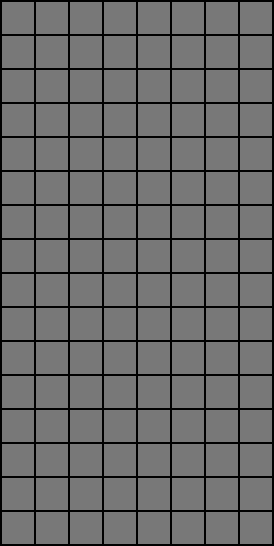

In [20]:
@torch.no_grad()
def plot_reconstructions(model):
    model.eval()
    img, _ = next(iter(test_loader))
    img = img.to("mps")
    output = model(img)
    display(
        torchvision.transforms.ToPILImage()(
            torchvision.utils.make_grid(
                output
            ),
        )
    )

plot_reconstructions(model)

In [ ]:
from collections import Counter

@torch.no_grad()
def codebook_usage(model, loader):
    model.eval()
    counter = Counter()
    for img, _ in tqdm(loader, desc="Calculating codebook usage"):
        img = img.to("mps")
        output = model(img)
        idxs = output[4]
        counter.update(idxs.cpu().numpy().flatten())
    return counter

# plot codebook usage
usasge = codebook_usage(model, test_loader)
plt.figure(figsize=(20, 5))
plt.imshow(
    torch.tensor([usasge[i] for i in range(512)]).reshape(16, 32).numpy(),
    cmap="hot",
)
plt.colorbar()
plt.show()

In [ ]:
print(len(usasge))